https://pandas.pydata.org/docs/user_guide/10min.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px

from wt_import import Wt_Importer


Set file for analysis

In [2]:
wt_full_sample = 'C:\\Users\\ecountrywood\\dev\\pandas\\data\\PA_sample_data.csv'
wt_short_sample = 'C:\\Users\\ecountrywood\\dev\\pandas\\data\\PA_sample_data_short.csv'
wt_micro_sample = "C:\\Users\\ecountrywood\\dev\\pandas\\data\\PA_micro.csv"
vv_data_sample = "C:\\Users\\ecountrywood\\dev\\pandas\\data\\volt-var\\EUT_20_2.csv"
watt_var_sample = "C:\\Users\\ecountrywood\\dev\\pandas\\data\\watt-var\\eut_100.csv"
volt_watt_sample = "C:\\Users\\ecountrywood\\dev\\pandas\\data\\volt-watt\\VW_CH1_100_sample_fix.csv"

df = Wt_Importer(volt_watt_sample).df
df.head()

,Store No.,Date,Time,Millisecond,U-1-Total,I-1-Total,P-1-Total,S-1-Total,Q-1-Total,PF-1-Total,...,CfU-1-Total,CfI-1-Total,I-2-Total,P-2-Total,S-2-Total,Q-2-Total,PF-2-Total,Phi-2-Total,FreqU-2-Total,FreqI-2-Total
1,1,2022/04/04,12:02:59,354,120.640,20.793,2510.0,2510.0,-41.2,0.99986,...,NaN,NaN,20.870,2520.0,2520.0,-33.2,0.99991,-0.757,60.001,59.996
2,2,2022/04/04,12:02:59,854,120.637,20.760,2500.0,2500.0,-42.5,0.99986,...,NaN,NaN,20.898,2520.0,2520.0,-33.2,0.99991,-0.754,60.002,60.004
3,3,2022/04/04,12:03:00,353,120.642,20.777,2500.0,2500.0,-40.8,0.99987,...,NaN,NaN,20.867,2510.0,2510.0,-32.8,0.99992,-0.747,60.001,59.999
4,4,2022/04/04,12:03:00,852,120.634,20.789,2500.0,2510.0,-41.8,0.99986,...,NaN,NaN,20.886,2520.0,2520.0,-32.3,0.99992,-0.736,60.000,59.999
5,5,2022/04/04,12:03:01,353,120.624,20.806,2510.0,2510.0,-42.0,0.99986,...,NaN,NaN,20.876,2520.0,2520.0,-34.8,0.99990,-0.792,60.002,59.998


Begin working with the dataframe:
- take a subset of the columns

In [3]:

df['sumV'] = df['U-1-Total'] + df['U-2-Total']
df['sumP'] = df['P-1-Total'] + df['P-2-Total']

Extract X and Y timeseries

In [4]:
vx = df['sumV'].to_numpy(dtype=float, copy=True)   # Voltage Timeseries
vy = df['sumP'].to_numpy(dtype=float, copy=True)   # Var Timeseries

Downsample for easier stepfinding

In [5]:
n = 1# take every 10th sample
vx = vx[::n] 
vy = vy[::n]

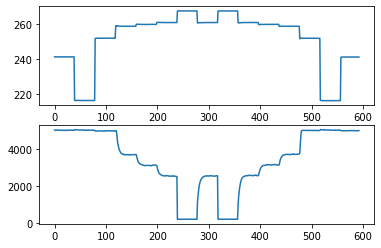

In [6]:

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.figsize=(16,2); ax2.figsize=(16,2)
ax1.plot(vx); ax2.plot(vy)

# Step finding

numpy.diff()

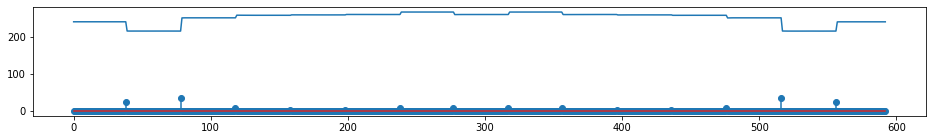

In [7]:
vxdif = np.abs(np.diff(vx, append=vx[0] ))
plt.figure(figsize=(16,2))
plt.stem(vxdif)
plt.plot(vx)

create binary array where steps are represented by boolean(1)

<StemContainer object of 3 artists>

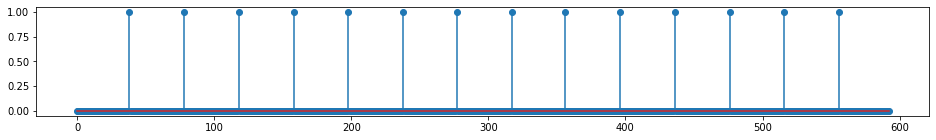

In [8]:
vxbin = vxdif > 0.5
plt.figure(figsize=(16,2))
plt.stem(vxbin)

Get the index of each change point and plot change poits over original timeseries

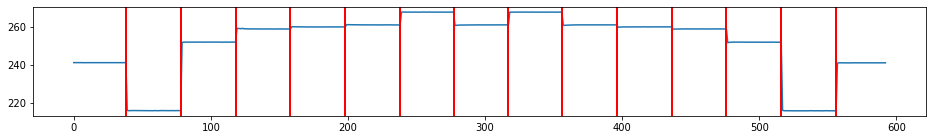

In [15]:
from Numpy_utils import plot_change_points 

change_points = np.where(vxbin==1)[0]
plot_change_points(vx,change_points)

In [10]:
from Numpy_utils import get_change_points
change_points
print(len(change_points) -1)

13


Get average value of each step in timeseries:
- define a window (as percent of step length) 
- place the uppermost window edge at uppermost edge of each interval defined by change locations 
- take the mean of the timeseries values in the window

In [11]:
from Numpy_utils import get_step_values
cp = get_change_points(vx, threshold=0.5) # stepss over half a volt
print(cp)
x_idxs, x_vals = get_step_values(vx,cp)
y_idxs, y_vals = get_step_values(vy,cp)

[ 38  78 118 158 198 238 277 317 356 396 436 476 516 556]


<StemContainer object of 3 artists>

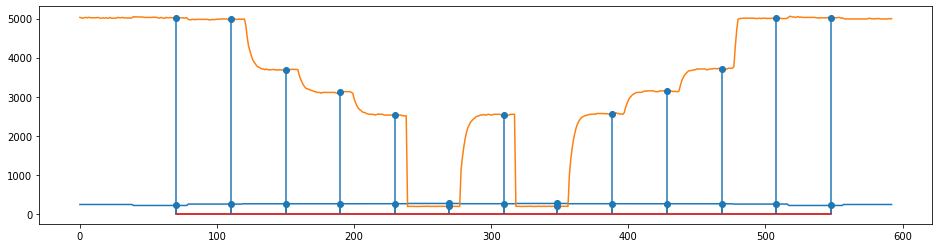

In [14]:
plt.figure(figsize=(16,4))
plt.plot(vx)
plt.stem(x_idxs,x_vals)
plt.plot(vy)
plt.stem(y_idxs,y_vals)

In [20]:
DFXY = pd.DataFrame({'x': x_vals,
                   'y': y_vals})
DFXY

,x,y
0,216,5020
1,252,4985
2,258,3691
3,259,3116
4,261,2528
5,267,192
6,261,2541
7,267,193
8,261,2566
9,259,3143


In [74]:
percent_x_tol = 0.01; percent_y_tol = 0.05
xn = 240; yn = 5000
x_tol = percent_x_tol*xn; y_tol = percent_y_tol*yn


D = pd.DataFrame({
                    'xmin': (DFXY.x)-x_tol,
                    'x': (DFXY.x),
                    'xmax': (DFXY.x)+x_tol,
                    'ymin': (DFXY.y)-y_tol,
                    'y': (DFXY.y),
                    'ymax': (DFXY.y)+y_tol           
                     })
D['pass'] = ((D.x > D.xmin) & (D.x < D.xmax) & (D.y > D.ymin) & (D.y < D.ymax))
D


,xmin,x,xmax,ymin,y,ymax,pass
0,213.6,216,218.4,4770.0,5020,5270.0,True
1,249.6,252,254.4,4735.0,4985,5235.0,True
2,255.6,258,260.4,3441.0,3691,3941.0,True
3,256.6,259,261.4,2866.0,3116,3366.0,True
4,258.6,261,263.4,2278.0,2528,2778.0,True
5,264.6,267,269.4,-58.0,192,442.0,True
6,258.6,261,263.4,2291.0,2541,2791.0,True
7,264.6,267,269.4,-57.0,193,443.0,True
8,258.6,261,263.4,2316.0,2566,2816.0,True
9,256.6,259,261.4,2893.0,3143,3393.0,True
